In [1]:
import dotenv, os

from github import Github
from github.Issue import Issue
from github.PaginatedList import PaginatedList

from datetime import datetime, timezone, timedelta
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import pandas as pd

from tqdm import tqdm

In [2]:
# Load api key
dotenv.load_dotenv()
GIT_API_KEY = os.getenv('GITHUB_TOKEN')

In [3]:
github = Github(GIT_API_KEY)
org_name = 'Aparking'
repo_name = 'AparKing_Backend'
milestone_name = 'Sprint 1'

org = github.get_organization(org_name)
repo = org.get_repo(repo_name)

contributors = repo.get_contributors().get_page(0)
milestones = repo.get_milestones().get_page(0)
milestone = next(filter(lambda m: m.title == milestone_name, milestones), None)

raw_issues = repo.get_issues(state='all')
issues = list(filter(lambda i: not i.pull_request, tqdm(raw_issues)))
issues.sort(key=lambda i: i.created_at)

166it [01:00,  2.73it/s]


In [10]:
# General chart

def calculate_performance(issues: list, start = '', end = ''):
    """
    Calculate arrays for plot with matplotlib.

    If start or end are None, the dates will be taken
    from issues.
    - start will take first created_at from issues.
    - end will take last closed_at from issues.

    Parameters
    ----------
    issues: list of issues
    start: start date using iso format (Y-M-D).
    end: end date using iso format (Y-M-D).

    Returns
    -------
    dates: list of dates from start to end.
    closing: list of closed issues by index day.
    remaining: list of remaining history points.
    """
    if not issues:
        raise ValueError('issues cannot be empty list or None')
    issues.sort(key=lambda i: i.created_at)
    
    start_date = issues[0].created_at.date() if not start else datetime.fromisoformat(start).date()
    end_date = datetime.now().date() if not end else datetime.fromisoformat(end).date()
    issues = list(filter(lambda i: start_date <= i.created_at.date() <= end_date, issues))
    
    dates = np.arange(start_date, end_date)
    closing = np.zeros(dates.shape)
    for i in issues:
        if hasattr(i, 'closed_at') and i.closed_at:
            if (closed_date := i.closed_at.date()) in dates:
                date_index = np.where(dates == closed_date)[0]
                closing[date_index] += 1
    
    remaining = np.zeros(dates.shape)
    story_points = len(issues)
    for i,points in enumerate(closing):
        story_points -= points
        remaining[i] = story_points

    return dates,closing,remaining

def plot_performance(dates, closing, remaining, title='Proyect'):
    plt.figure(figsize=(15, 5))
    plt.plot(dates, remaining, label='Remaining Points', color='blue')
    plt.bar(dates, closing, label="Closed Issues", color='gold')
    plt.title(title)
    plt.xlabel("Date")
    plt.ylabel("History Points")
    
    plt.legend()
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%d-%m"))
    plt.xticks(rotation=45, ticks=dates)
    plt.grid(True)
    plt.savefig(f"{title}.png")
    plt.show()

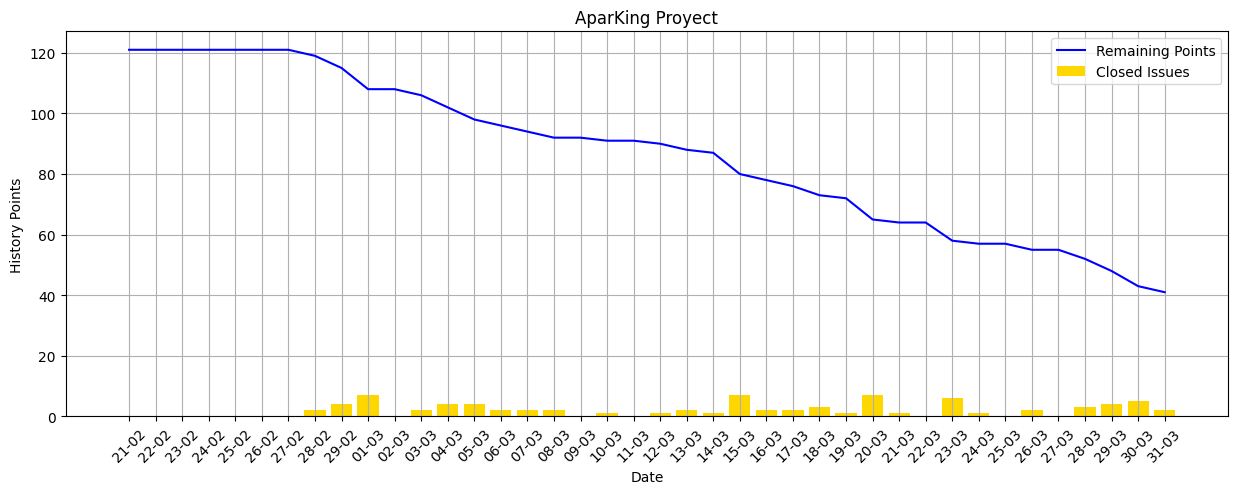

In [11]:
dates, closing, remaining = calculate_performance(issues)
plot_performance(dates, closing, remaining, 'AparKing Proyect')

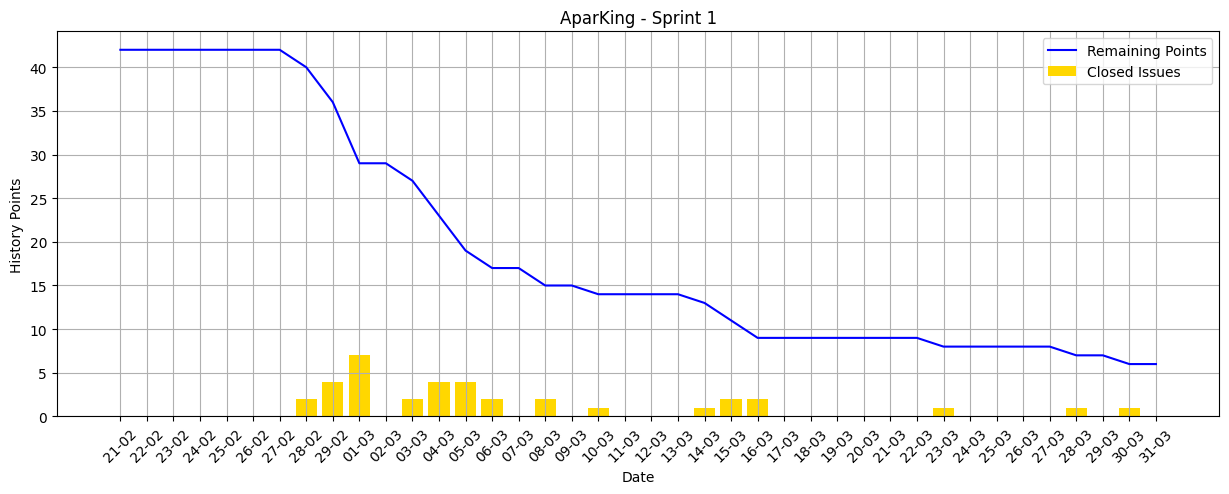

In [12]:
sprint1_issues = list(filter(lambda i: i.milestone == milestones[0], issues))
sprint1_issues.sort(key=lambda i: i.created_at)
dates, closing, remaining = calculate_performance(sprint1_issues, str(milestones[0].created_at), '2024-04-01')
plot_performance(dates, closing, remaining, 'AparKing - Sprint 1')

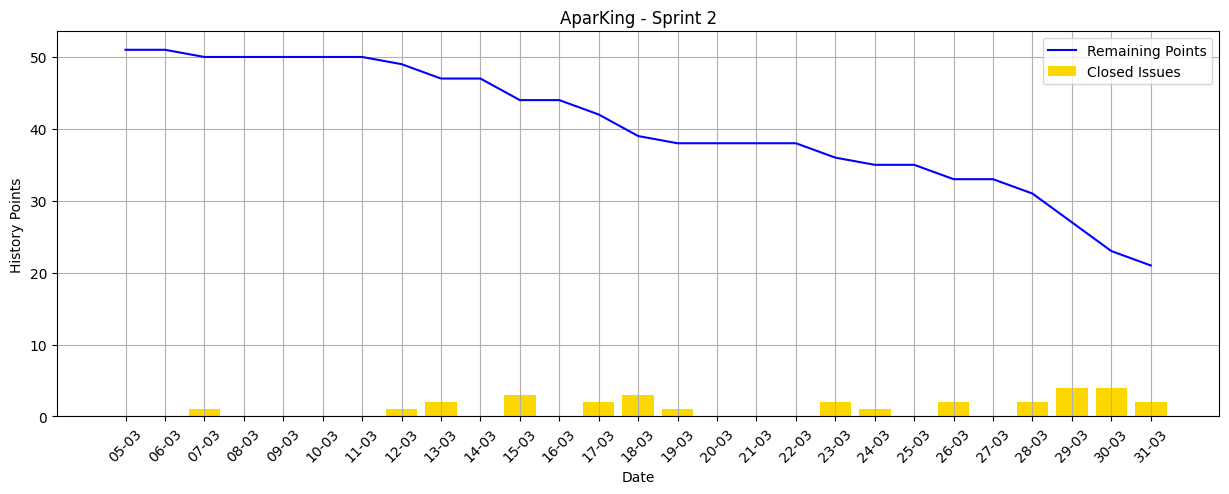

In [13]:
sprint1_issues = list(filter(lambda i: i.milestone == milestones[1], issues))
sprint1_issues.sort(key=lambda i: i.created_at)
dates, closing, remaining = calculate_performance(sprint1_issues, '2024-03-05', '2024-04-01')
plot_performance(dates, closing, remaining, 'AparKing - Sprint 2')